In [122]:
import numpy as np
import pandas as pd
import requests
#from google.colab import drive

import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import os
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import cv2
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [123]:
from albumentations import (
    Compose,
    HorizontalFlip,
    VerticalFlip,
    RandomRotate90,
    ShiftScaleRotate,
    RandomBrightnessContrast,
    Resize,
)

In [124]:
#calling the saved model
from tensorflow.keras.models import load_model
model = load_model("unet_model.h5")

In [126]:
# File path to the Data Entry of the patients file
file_path_patients = 'data/Data_Entry_2017.csv'
# File path to the Data Entry of the disease classification
file_path_seg = 'data/BBox_List_2017.csv'

In [127]:
# reading the patients' diagnosis information
df_patient = pd.read_csv(file_path_patients, usecols=['Image Index','Finding Labels','Follow-up #','Patient ID','Patient Age','Patient Gender','View Position','OriginalImage[Width','Height]','OriginalImagePixelSpacing[x','y]'])
df_patient.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143


In [128]:
unique_labels = df_patient["Finding Labels"].unique()
print(unique_labels)

['Cardiomegaly' 'Cardiomegaly|Emphysema' 'Cardiomegaly|Effusion'
 'No Finding' 'Hernia' 'Hernia|Infiltration' 'Mass|Nodule' 'Infiltration'
 'Effusion|Infiltration' 'Nodule' 'Emphysema' 'Effusion' 'Atelectasis'
 'Effusion|Mass' 'Emphysema|Pneumothorax' 'Pleural_Thickening'
 'Effusion|Emphysema|Infiltration|Pneumothorax'
 'Emphysema|Infiltration|Pleural_Thickening|Pneumothorax'
 'Effusion|Pneumonia|Pneumothorax' 'Pneumothorax'
 'Effusion|Infiltration|Pneumothorax' 'Infiltration|Mass'
 'Infiltration|Mass|Pneumothorax' 'Mass'
 'Cardiomegaly|Infiltration|Mass|Nodule'
 'Cardiomegaly|Effusion|Emphysema|Mass'
 'Atelectasis|Cardiomegaly|Emphysema|Mass|Pneumothorax' 'Emphysema|Mass'
 'Emphysema|Mass|Pneumothorax' 'Atelectasis|Pneumothorax'
 'Cardiomegaly|Emphysema|Pneumothorax' 'Mass|Pleural_Thickening'
 'Cardiomegaly|Mass|Pleural_Thickening' 'Effusion|Infiltration|Nodule'
 'Atelectasis|Effusion|Pleural_Thickening' 'Fibrosis|Infiltration'
 'Fibrosis|Infiltration|Pleural_Thickening' 'Fibrosis'
 '

In [129]:
# Count occurrences of each label
label_counts = df_patient["Finding Labels"].value_counts()

# Select top 10 most common labels
top_10_labels = label_counts.head(10)

# Convert index to a list
top_10_labels_list = top_10_labels.index.tolist()

print(top_10_labels_list)

['No Finding', 'Infiltration', 'Atelectasis', 'Effusion', 'Nodule', 'Pneumothorax', 'Mass', 'Effusion|Infiltration', 'Atelectasis|Infiltration', 'Consolidation']


In [130]:
# reading the lung segmentation dataset
df_segmentation = pd.read_csv(file_path_seg, usecols=['Image Index','Finding Label','Bbox [x','y','w','h]'])
df_segmentation.head()

,Image Index,Finding Label,Bbox [x,y,w,h]
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695


In [131]:
# Define paths to datasets
train_dataset_path = "chest-xray-masks-and-labels/Lung Segmentation/CXR_png"
mask_directory = "chest-xray-masks-and-labels/Lung Segmentation/masks"
test_dataset_path = "chest-xray-masks-and-labels/Lung Segmentation/test"

In [132]:
import numpy as np
import skimage
from skimage.io import imread
from keras.preprocessing.image import img_to_array

# Function to preprocess a single X-ray image
def preprocess_xray_image(image_path):
    # Load and preprocess X-ray image
    image = load_img(image_path, color_mode="grayscale", target_size=(256, 256))
    image_array = img_to_array(image) / 255.0
    return image_array
    
class LungSegmentation:
    def __init__(self):
        self.segmented_masks = None

    def segment_lung_regions(self, images, batch_size=10):
        segmented_masks = []
        for i in range(0, len(images), batch_size):
            batch = images[i:i + batch_size]
            # Replace `model.predict(batch)` with your actual lung segmentation method
            masks = model.predict(batch)
            segmented_masks.extend(masks)
        self.segmented_masks = np.array(segmented_masks)

    def threshold_and_mask_images(self, threshold=0.1, X_images=None):
        if self.segmented_masks is None:
            raise ValueError("Segmented masks have not been generated yet. Please call segment_lung_regions first.")
        
        # Threshold the predicted masks to obtain binary masks
        binary_masks = (self.segmented_masks > threshold).astype(np.uint8)
    
        # Debug print to check final shape of binary_masks
        print("Adjusted binary masks shape:", binary_masks.shape)

        # Apply the binary masks to the original X-ray images
        masked_images = X_images * binary_masks  # Ensure proper shape for broadcasting
        return masked_images
        
    def extract_features(self):
        if self.segmented_masks is None:
            raise ValueError("Segmented masks have not been generated yet. Please call segment_lung_regions first.")
        
        features = []
        for mask in self.segmented_masks:
            # Ensure the mask is binary
            mask = (mask > 0).astype(np.uint8)

            # Texture Analysis
            glcm = greycomatrix(mask, distances=[1], angles=[0], levels=2)
            texture_features = greycoprops(glcm, prop='contrast'), \
                               greycoprops(glcm, prop='energy'), \
                               greycoprops(glcm, prop='homogeneity'), \
                               greycoprops(glcm, prop='correlation')

            # Shape Analysis
            region_props = regionprops(mask)[0]
            area = region_props.area
            perimeter = region_props.perimeter
            eccentricity = region_props.eccentricity
            solidity = region_props.solidity
            compactness = (perimeter ** 2) / (4 * np.pi * area)

            # Histogram-Based Features
            histogram_features = np.histogram(mask.flatten(), bins=2, range=(0, 1))[0]

            # Gradient-Based Features
            gradient_magnitude = np.sqrt(sobel(mask)**2 + sobel(mask.T)**2)
            gradient_features = np.mean(gradient_magnitude), np.std(gradient_magnitude), np.max(gradient_magnitude)

            # Statistical Features
            statistical_features = np.mean(mask), np.median(mask), np.var(mask), np.std(mask)
            
            # Combine features
            combined_features = np.concatenate((
                np.asarray(texture_features).flatten(),
                [area, perimeter, eccentricity, solidity, compactness],
                histogram_features,
                gradient_features,
                statistical_features
            ))

            features.append(combined_features)

        return np.array(features)

In [133]:
#ensemble-model

In [12]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Assuming df_patient is your DataFrame containing patient X-ray data and labels
unique_labels = top_10_labels_list

# Filter out images with valid labels
valid_data_entry = df_patient[df_patient["Finding Labels"].isin(unique_labels)]

# Preprocess X-ray images
image_paths = [os.path.join("data/images", filename) for filename in valid_data_entry["Image Index"]]
preprocessed_images = []
y_labels = []

# Boolean flag to track whether the condition is met
found_image = False

for image_path, label in zip(image_paths, valid_data_entry["Finding Labels"]):
    try:
        preprocessed_image = preprocess_xray_image(image_path)
        preprocessed_images.append(preprocessed_image)
        y_labels.append(label)
        
        # Check if the current image filename is "00030805_000.png"
        if os.path.basename(image_path) == '00010092_000.png':
            found_image = True
            print("True")
            break  # Stop the loop when reaching the specified filename
    except FileNotFoundError:
        if os.path.basename(image_path) == '00006444_004.png':
            print("True")
            break  # Stop the loop when reaching the specified filename
        print("File not found:", image_path)

if preprocessed_images:
    X_images = np.array(preprocessed_images)
    y_labels = np.array(y_labels)
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_labels_encoded = label_encoder.fit_transform(y_labels)
    num_classes = len(label_encoder.classes_)
    y_labels_categorical = to_categorical(y_labels_encoded, num_classes=num_classes)
    
    # Split data
    #X_train, X_test, y_train, y_test = train_test_split(X_images, y_labels_categorical, test_size=0.2, random_state=42)

    print("Shape of preprocessed images:", X_images.shape)
    print("Length of disease labels:", len(y_labels))
    print("Number of classes:", num_classes)
else:
    print("No preprocessed images available.")

True
Shape of preprocessed images: (31395, 256, 256, 1)
Length of disease labels: 31395
Number of classes: 10


In [134]:
X_images.shape

(31395, 256, 256, 1)

In [135]:
# Filter X_images based on labels in top_10_labels_list
filtered_indices = [i for i, label in enumerate(y_labels) if label in top_10_labels_list]
X_images_filtered = X_images[filtered_indices]

# Consider only the first 10,000 images from X_images_filtered
X_images_subset = X_images_filtered[:10000]

# Initialize and perform lung segmentation on the subset of filtered X_images
lung_segmenter = LungSegmentation()
lung_segmenter.segment_lung_regions(X_images_subset)

1/1 [==============================] - 0s 12ms/step


In [136]:
# Filter X_images based on labels in top_10_labels_list

filtered_indices = [i for i, label in enumerate(y_labels) if label in top_10_labels_list]
X_images_filtered = X_images[filtered_indices]

# Consider only the first 10,000 images from X_images_filtered
X_images_subset = X_images_filtered[:10000]

# Threshold and mask filtered X_images subset
masked_images = lung_segmenter.threshold_and_mask_images(threshold=0.1, X_images=X_images_subset)
#features = lung_segmenter.extract_features()

Adjusted binary masks shape: (10000, 256, 256, 1)


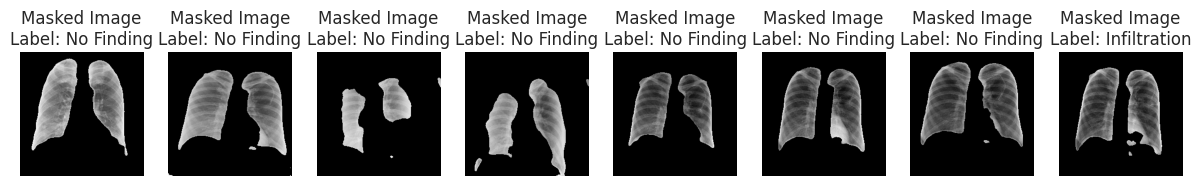

In [138]:
def plot_images_with_labels(images, labels, titles, figsize=(15, 5)):
    num_images = len(images)
    plt.figure(figsize=figsize)
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f'{titles[i]}\nLabel: {labels[i]}')
        plt.axis('off')
    plt.show()

plot_images_with_labels([masked_images[i] for i in range(8)],
                        [y_labels[i] for i in range(8)],
                        ['Masked Image'] * 8)

In [62]:
from tensorflow.keras.applications import ResNet50, DenseNet121
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, GlobalAveragePooling2D, concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import numpy as np
from tensorflow.keras.metrics import Recall

# Assuming X_images is your original dataset with shape (3366, 256, 256, 1)
#X_images_rgb = np.repeat(lung_masks, 3, axis=-1)  # Repeat the grayscale channel across the RGB channels

def create_ensemble_model():
    # Define the input tensor
    input_tensor = Input(shape=(256, 256, 1), name='input')  # Change input shape to (256, 256, 1)

    # Convert grayscale images to RGB using a convolutional layer
    x = tf.keras.layers.Conv2D(3, (3, 3), activation='relu')(input_tensor)  # Convert grayscale to RGB

    # Load the first base model with a unique prefix
    base_model1 = ResNet50(weights=None, include_top=False, input_tensor=x)  # Pass x as input tensor and use no pre-trained weights
    for layer in base_model1.layers:
        layer._name = 'model1_' + layer.name  # Rename layers
    base_model1.trainable = False  # Freeze the model

    # Load the second base model with a different unique prefix
    base_model2 = DenseNet121(weights=None, include_top=False, input_tensor=x)  # Pass x as input tensor and use no pre-trained weights
    for layer in base_model2.layers:
        layer._name = 'model2_' + layer.name  # Rename layers
    base_model2.trainable = False  # Freeze the model

    # Apply global average pooling to the outputs of both models
    x1 = GlobalAveragePooling2D()(base_model1.output)
    x2 = GlobalAveragePooling2D()(base_model2.output)

    # Concatenate the pooled outputs
    x = concatenate([x1, x2], name='concatenate_layer')

    # Continue as usual
    x = Dropout(0.5, name='dropout')(x)
    x = Dense(256, activation='relu', name='dense_relu')(x)
    output = Dense(10, activation='softmax', name='output')(x)  # Assuming 10 classes

    # Create the final model
    model = Model(inputs=input_tensor, outputs=output, name='ensemble_model')
    return model


# Assuming y_labels are your raw labels
label_encoder = LabelEncoder()
y_labels_encoded = label_encoder.fit_transform(y_labels)  # Assuming y_labels are your original labels
y_labels_categorical = to_categorical(y_labels_encoded)

# Filter out labels not in the top 10 list
filtered_indices = [i for i, label in enumerate(y_labels) if label in top_10_labels_list]
X_images_filtered = X_images[filtered_indices]
y_labels_filtered = y_labels_categorical[filtered_indices]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_images_filtered, y_labels_filtered, test_size=0.2, random_state=42)

# Instantiate and compile the model
ensemble_model = create_ensemble_model()
ensemble_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Recall()])

# Train the model on the training data
try:
    ensemble_model.fit(X_train, y_train, batch_size=16, epochs=10, validation_split=0.2)
except Exception as e:
    print("Error during model fitting:", str(e))

# Evaluate the model on the testing data
evaluation_results = ensemble_model.evaluate(X_test, y_test)
print(f'Test Loss: {evaluation_results[0]}, Test Accuracy: {evaluation_results[1]}, Test Recall: {evaluation_results[2]}')

Epoch 1/10
1050/1050 [==============================] - 48s 41ms/step - loss: 0.5345 - accuracy: 0.8507 - recall_1: 0.8401 - val_loss: 0.5317 - val_accuracy: 0.8427 - val_recall_1: 0.8427
Epoch 2/10
1050/1050 [==============================] - 34s 33ms/step - loss: 0.5117 - accuracy: 0.8513 - recall_1: 0.8513 - val_loss: 0.5333 - val_accuracy: 0.8427 - val_recall_1: 0.8427
Epoch 3/10
1050/1050 [==============================] - 34s 33ms/step - loss: 0.5098 - accuracy: 0.8513 - recall_1: 0.8513 - val_loss: 0.5289 - val_accuracy: 0.8427 - val_recall_1: 0.8427
Epoch 4/10
1050/1050 [==============================] - 35s 34ms/step - loss: 0.5100 - accuracy: 0.8513 - recall_1: 0.8513 - val_loss: 0.5322 - val_accuracy: 0.8427 - val_recall_1: 0.8427
Epoch 5/10
1050/1050 [==============================] - 35s 33ms/step - loss: 0.5091 - accuracy: 0.8513 - recall_1: 0.8513 - val_loss: 0.5256 - val_accuracy: 0.8427 - val_recall_1: 0.8427
Epoch 6/10
1050/1050 [==============================] - 35s 

1/1 [==============================] - 0s 21ms/step


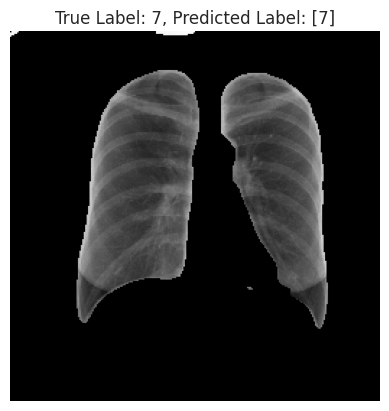

In [140]:
import matplotlib.pyplot as plt

# Select a single sample for visualization (for example, the first sample in the test set)
sample_index = 1824
sample_image = masked_images[sample_index]
sample_label = y_labels_filtered[sample_index]  
sample_label = np.argmax(sample_label)

# True class name (without encoding)
true_class_name = sample_label

predictions = ensemble_model.predict(np.expand_dims(sample_image, axis=0))
predicted_class = np.argmax(predictions, axis=1)

predicted_class_name = predicted_class

# Overlay the predicted class label on the sample image
plt.imshow(sample_image,cmap='gray')

# Display true and predicted labels as text
plt.title(f'True Label: {true_class_name}, Predicted Label: {predicted_class_name}')
plt.axis('off')
plt.show()

In [38]:
# Select a single sample for visualization (for example, the first sample in the test set)
sample_index = 2
sample_image = X_train[sample_index]
sample_label = np.argmax(y_train[sample_index])  # Get the true label of the sample
print("True label:", sample_label)

# Predict the class label for the input sample using the ensemble model
sample_prediction = ensemble_model.predict(np.expand_dims(sample_image, axis=0))
predicted_label = np.argmax(sample_prediction)
print("Predicted label:", predicted_label)

True label: 7
1/1 [==============================] - 0s 24ms/step
Predicted label: 7


In [121]:
ensemble_model.summary()

Model: "ensemble_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 model2_model1_input (Input  [(None, 256, 256, 1)]        0         []                            
 Layer)                                                                                           
                                                                                                  
 model2_model1_conv2d_1 (Co  (None, 254, 254, 3)          30        ['model2_model1_input[0][0]'] 
 nv2D)                                                                                            
                                                                                                  
 model2_zero_padding2d_2 (Z  (None, 260, 260, 3)          0         ['model2_model1_conv2d_1[0][0]
 eroPadding2D)                                                      ']               